# Setup

### Importing Dependencies and Data

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv', sep=',')

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

print(X.shape)
print(y.shape)

(253680, 21)
(253680,)


### Implementing functions

In [26]:
def report_info(y_test, y_pred, test_set_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('\nTest set:', test_set_name)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('recall:', recall)
    print('f1:', f1)

    cm1 = confusion_matrix(y_test,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm1,show_absolute=True,show_normed=True, colorbar=True)
    ax.set_title('\nConfusion Matrix for ' + test_set_name + ' test set')
    plt.show()

def get_type_errors(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    fp = cm[0, 1]
    fn = cm[1, 0]

    return [fp, fn]

# Part 1: Demonstrating the Problem  
I'll illustrate this for our logistic regression model but it holds true for every approach we used since the problem is with the train and test distribution.


Test set: unbalanced
Accuracy: 0.865874329864396
Precision: 0.5451977401129944
recall: 0.16549949978562242
f1: 0.25391952636772286


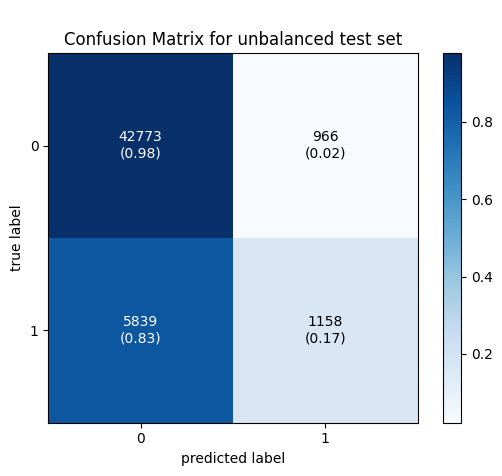

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_demo_model = LogisticRegression(random_state=42)
log_demo_model.fit(X_train_scaled, y_train)

y_pred = log_demo_model.predict(X_test_scaled)

report_info(y_test, y_pred, 'unbalanced')
unbalanced_accuracy = accuracy_score(y_test, y_pred)


Test set: balanced
Accuracy: 0.5719594111762184
Precision: 0.8846447669977082
recall: 0.16549949978562242
f1: 0.27883457741391765


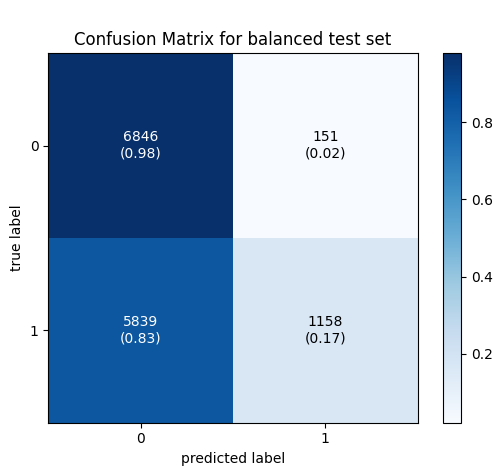

In [28]:
undersample = RandomUnderSampler(sampling_strategy="majority")
X_test_resampled, y_test_resampled = undersample.fit_resample(X_test_scaled, y_test)

y_pred_resampled = log_demo_model.predict(X_test_resampled)

report_info(y_test_resampled, y_pred_resampled, 'balanced')
balanced_accuracy = accuracy_score(y_test_resampled, y_pred_resampled)

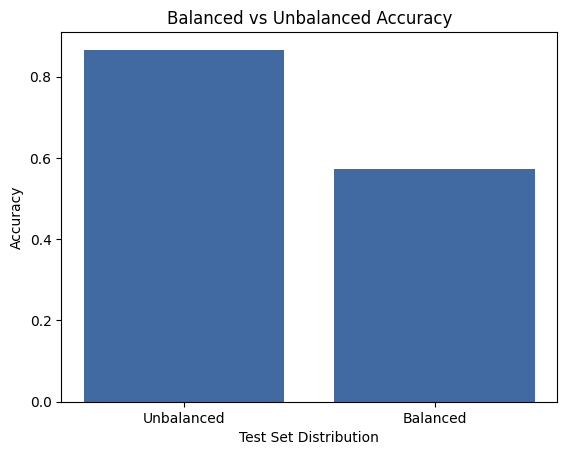

In [29]:
accuracies = [unbalanced_accuracy, balanced_accuracy]
labels = ['Unbalanced', 'Balanced']

plt.bar(labels, accuracies, color='#416AA3')
plt.xlabel('Test Set Distribution')
plt.ylabel('Accuracy')
plt.title('Balanced vs Unbalanced Accuracy')
plt.show()


Balanced accuracy is much worse suggesting that the model was over-fitting on the distribution of the data rather than the features.

# Part 2: Balancing the Training Dataset

### Data Preparation

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersample = RandomUnderSampler()
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(y_train_under.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_under)
X_test_scaled = scaler.transform(X_test)

# Test sets to verify how the models perform on different distributions. 
# If the model is learning from the features rather than the distribution, we should expect more consistent performance across the test sets.
undersample_imbalance_positive = RandomUnderSampler(sampling_strategy={0: 300, 1: 3000})
undersample_imbalance_negative = RandomUnderSampler(sampling_strategy={0: 3000, 1: 300})
balanced = RandomUnderSampler(sampling_strategy={0: 3000, 1: 3000})

X_test_positive_imbalance, y_test_positive_imbalance = undersample_imbalance_positive.fit_resample(X_test_scaled, y_test)
X_test_negative_imbalance, y_test_negative_imbalance = undersample_imbalance_negative.fit_resample(X_test_scaled, y_test)
X_test_balanced, y_test_balanced = balanced.fit_resample(X_test_scaled, y_test)

print(y_test_positive_imbalance.value_counts())
print(y_test_negative_imbalance.value_counts())
print(y_test_balanced.value_counts())

Diabetes_binary
0.0    28349
1.0    28349
Name: count, dtype: int64
Diabetes_binary
1.0    3000
0.0     300
Name: count, dtype: int64
Diabetes_binary
0.0    3000
1.0     300
Name: count, dtype: int64
Diabetes_binary
0.0    3000
1.0    3000
Name: count, dtype: int64


# Part 3: Re-implementing Models with Corrected Dataset

### Logistic Regression


Test set: balanced
Accuracy: 0.7435
Precision: 0.7322734499205087
recall: 0.7676666666666667
f1: 0.7495524816924328


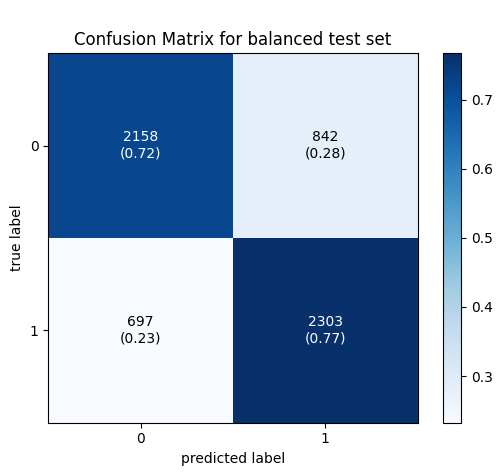


Test set: positively imbalanced
Accuracy: 0.7745454545454545
Precision: 0.9657308009909166
recall: 0.7796666666666666
f1: 0.8627812615271118


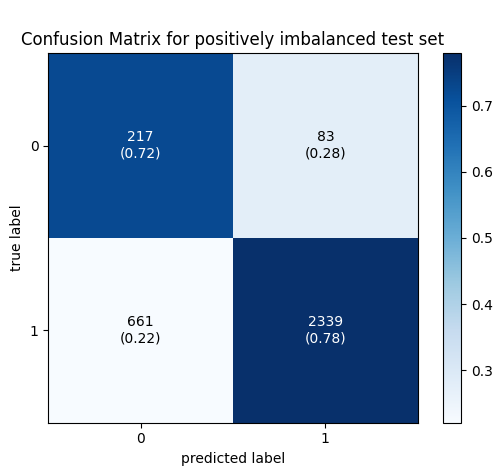


Test set: negatively imbalanced
Accuracy: 0.7227272727272728
Precision: 0.22272317403065825
recall: 0.8233333333333334
f1: 0.35060326472675657


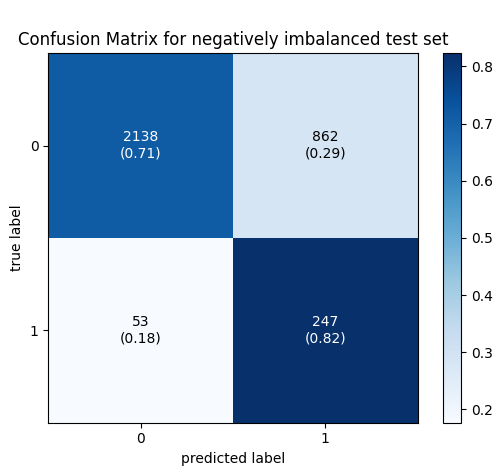

Logistic Regression Accuracy: 0.7454935642746544


In [31]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train_under)

y_pred = log_model.predict(X_test_balanced)
report_info(y_test_balanced, y_pred, 'balanced')
logistic_balanced_accuracy = accuracy_score(y_test_balanced, y_pred)
logistic_errors = get_type_errors(y_test_balanced, y_pred)

y_pred_positive_imbalance = log_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')
logistic_positive_imbalanced_accuracy = accuracy_score(y_test_positive_imbalance, y_pred_positive_imbalance)

y_pred_negative_imbalance = log_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')
logistic_negative_imbalanced_accuracy = accuracy_score(y_test_negative_imbalance, y_pred_negative_imbalance)

# k-fold cross-validation
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = cross_val_score(log_model, X_train_scaled, y_train_under, cv=kfold)
logistic_accuracy = cv_scores.mean()
print('Logistic Regression Accuracy:', logistic_accuracy)

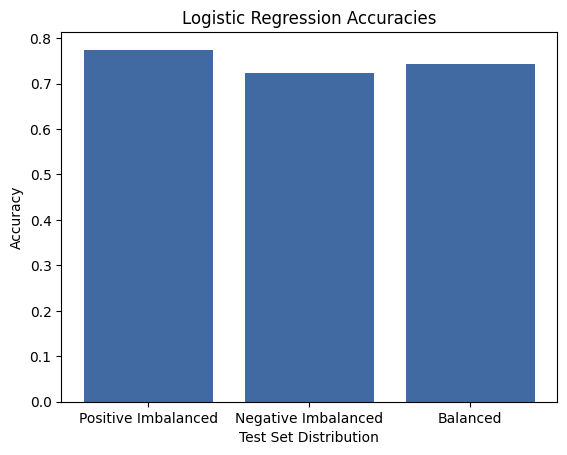

In [32]:
accuracies = [logistic_positive_imbalanced_accuracy, logistic_negative_imbalanced_accuracy, logistic_balanced_accuracy]
labels = ['Positive Imbalanced', 'Negative Imbalanced', 'Balanced']

plt.bar(labels, accuracies, color='#416AA3')
plt.xlabel('Test Set Distribution')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracies')
plt.show()

### Neural Network


Test set: balanced
Accuracy: 0.7503333333333333
Precision: 0.7305095150399018
recall: 0.7933333333333333
f1: 0.7606263982102908


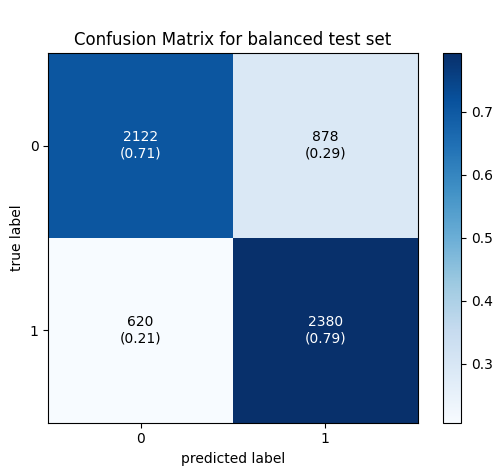


Test set: positively imbalanced
Accuracy: 0.7909090909090909
Precision: 0.9646017699115044
recall: 0.7993333333333333
f1: 0.8742253007655852


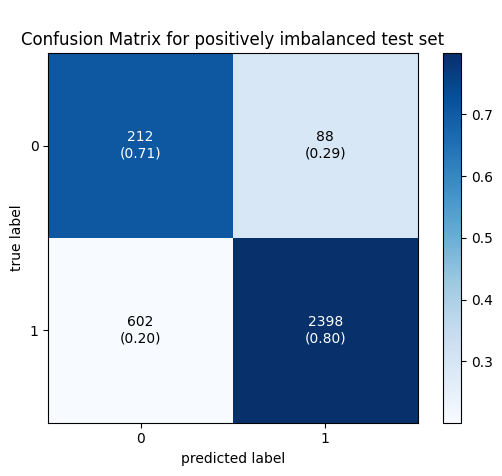


Test set: negatively imbalanced
Accuracy: 0.7169696969696969
Precision: 0.22144112478031636
recall: 0.84
f1: 0.3504867872044506


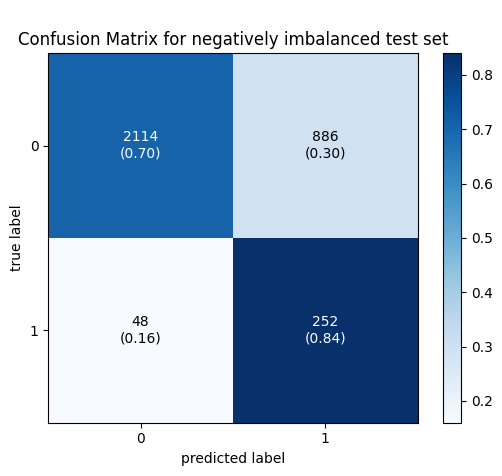

Neural Network Accuracy: 0.7497441016350878


In [33]:
nn_model = MLPClassifier(hidden_layer_sizes=[7], max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train_under)

y_pred = nn_model.predict(X_test_balanced)
report_info(y_test_balanced, y_pred, 'balanced')
nn_errors = get_type_errors(y_test_balanced, y_pred)

y_pred_positive_imbalance = nn_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = nn_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(nn_model, X_train_scaled, y_train_under, cv=kfold)
nn_accuracy = cv_scores.mean()
print('Neural Network Accuracy:', nn_accuracy)

### Decision Tree


Test set: balanced
Accuracy: 0.6505
Precision: 0.6511550050217609
recall: 0.6483333333333333
f1: 0.6497411057290796


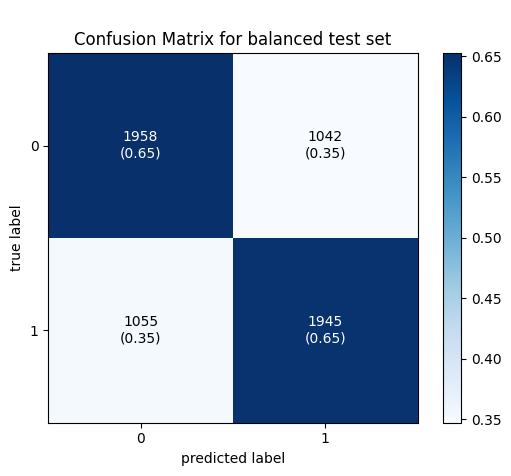


Test set: positively imbalanced
Accuracy: 0.6636363636363637
Precision: 0.9538904899135446
recall: 0.662
f1: 0.781582054309327


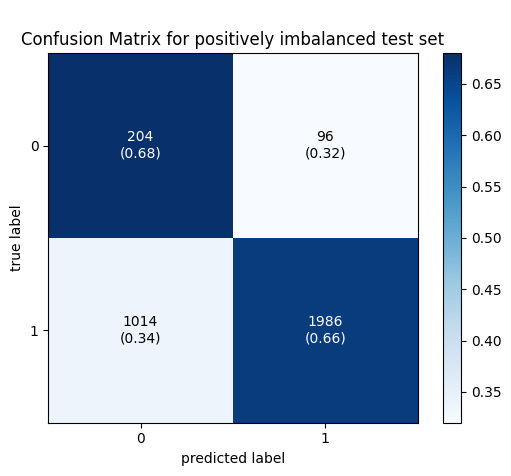


Test set: negatively imbalanced
Accuracy: 0.6709090909090909
Precision: 0.17412935323383086
recall: 0.7
f1: 0.27888446215139445


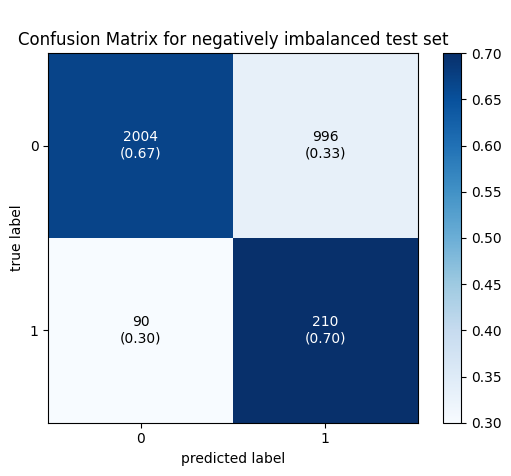

Decision Tree Accuracy: 0.6514691522911668


In [34]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model = dt_model.fit(X_train_scaled, y_train_under)

y_predict = dt_model.predict(X_test_balanced)
report_info(y_test_balanced, y_predict, 'balanced')
dt_errors = get_type_errors(y_test_balanced, y_pred)

y_pred_positive_imbalance = dt_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = dt_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train_under, cv=kfold)
dt_accuracy = cv_scores.mean()
print('Decision Tree Accuracy:', dt_accuracy)

### SVM


Test set: balanced
Accuracy: 0.748
Precision: 0.7231553689262148
recall: 0.8036666666666666
f1: 0.7612882854436376


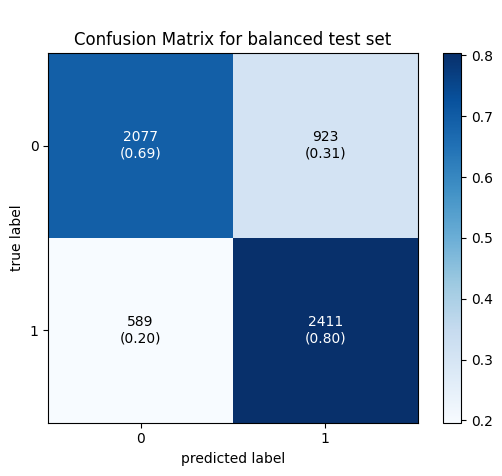


Test set: positively imbalanced
Accuracy: 0.7990909090909091
Precision: 0.9627722772277227
recall: 0.8103333333333333
f1: 0.88


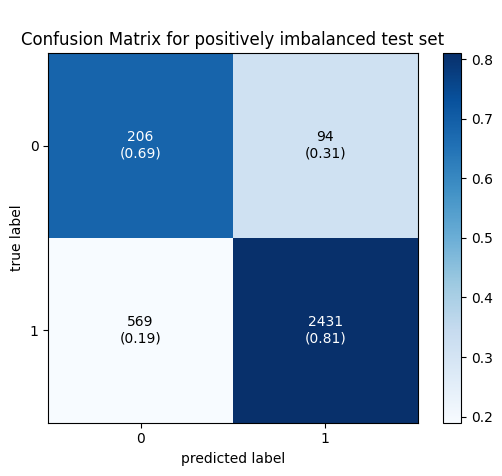


Test set: negatively imbalanced
Accuracy: 0.7048484848484848
Precision: 0.21680672268907564
recall: 0.86
f1: 0.3463087248322148


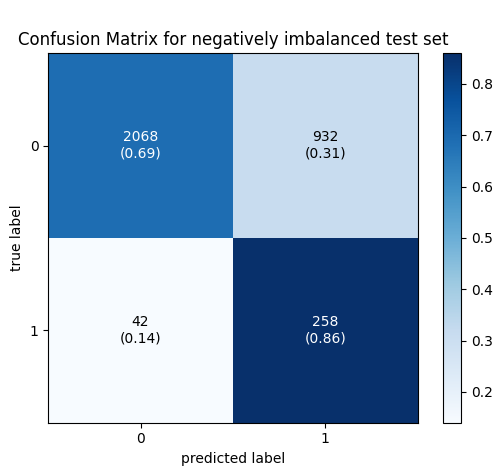

Support Vector Machine Accuracy: 0.7468869556668698


In [35]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train_under)

y_pred = svm_model.predict(X_test_balanced)
report_info(y_test_balanced, y_pred, 'balanced')
svm_errors = get_type_errors(y_test_balanced, y_pred)

y_pred_positive_imbalance = svm_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = svm_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train_under, cv=kfold)
svm_accuracy = cv_scores.mean()
print('Support Vector Machine Accuracy:', svm_accuracy)

Text(0.5, 1.0, 'Mean Model Accuracy')

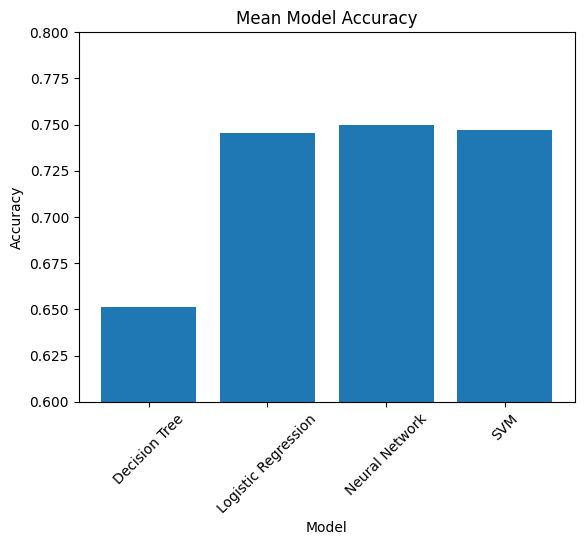

In [36]:
# Results of KFold for DT, LR, NN, SVM
accuracies = [dt_accuracy, logistic_accuracy, nn_accuracy, svm_accuracy]

plt.bar(['Decision Tree', 'Logistic Regression', 'Neural Network', 'SVM'], accuracies)
plt.xticks(rotation=45)
plt.ylim(0.6, 0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Mean Model Accuracy')

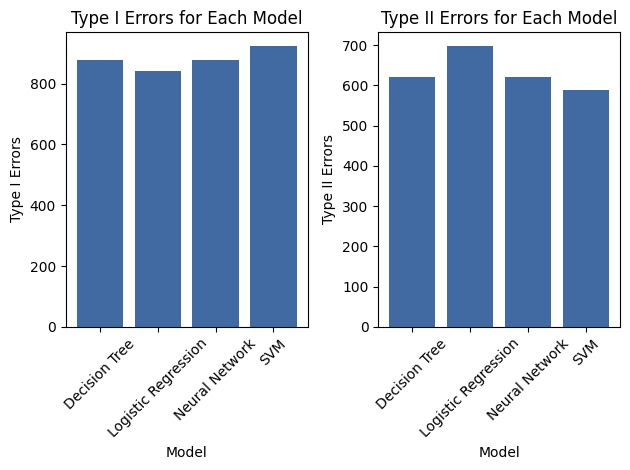

In [37]:
# Type I Errors
type_I_errors = [dt_errors[0], logistic_errors[0], nn_errors[0], svm_errors[0]]
labels = ['Decision Tree','Logistic Regression', 'Neural Network', 'SVM']

plt.subplot(1, 2, 1)
plt.bar(labels, type_I_errors, color='#416AA3')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Type I Errors')
plt.title('Type I Errors for Each Model')

# Type II Errors
type_II_errors = [dt_errors[1], logistic_errors[1], nn_errors[1], svm_errors[1]]

plt.subplot(1, 2, 2)
plt.bar(labels, type_II_errors, color='#416AA3')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Type II Errors')
plt.title('Type II Errors for Each Model')

plt.tight_layout()
plt.show()
